In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import os
import re
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [18]:
class AgeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)

        # get age, this assumes the age is the first int in the string before the first '_'
        age = float(img_name.split('_')[0])

        # Load image
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(age, dtype=torch.float32)

In [60]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),

    # significant transformations to force the model away from positional features
    transforms.RandomApply([transforms.RandomRotation([90, 90])], p=0.25),
    transforms.RandomApply([transforms.RandomRotation([180, 180])], p=0.25),
    transforms.RandomApply([transforms.RandomRotation([270, 270])], p=0.25),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
train_dataset = AgeDataset(root_dir='/Users/adrianlayer/BGGN240/Final Project/split_data/PD Patients/train', transform=transform)
test_dataset = AgeDataset(root_dir='/Users/adrianlayer/BGGN240/Final Project/split_data/PD Patients/test', transform=transform)
val_dataset = AgeDataset(root_dir='/Users/adrianlayer/BGGN240/Final Project/split_data/PD Patients/val', transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [61]:
# confirm filename format to extract age
for img, age in train_loader:
    print(img.shape, age)
    break

torch.Size([32, 1, 224, 224]) tensor([78., 76., 44., 59., 65., 67., 71., 71., 76., 77., 71., 81., 59., 56.,
        79., 55., 78., 71., 59., 74., 79., 76., 48., 77., 81., 76., 64., 76.,
        41., 78., 55., 55.])


In [68]:
# unedited model
model = models.efficientnet_b0(weights=None)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [69]:
def setup_model():
    model = models.efficientnet_b0(weights=None)

    # grayscale input
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    
    # regression output
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 1, bias=True)
    # increase dropout to combat overfitting
    model.classifier[0] = nn.Dropout(p=0.5, inplace=True)

    return model

def train(model, train_loader, val_loader, num_epochs=10, lr=1e-4, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else 
                         "mps" if torch.backends.mps.is_available() else
                         "cpu")
    print(f"Using {device}")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4) # *** TRYING WEIGHT DECAY TO COMBAT OVERFITTING ***

    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
            inputs, targets = inputs.to(device), targets.to(device)

            # forward
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs.view(-1), targets)  # flatten for regression
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print training statistics
        avg_train_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss}')

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1), targets)
                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'PD_effnetb0.pth')
            print(f'saved model at {best_val_loss} loss')

    print("Done")

def evaluate(model, test_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else 
                         "mps" if torch.backends.mps.is_available() else
                         "cpu")
    model.to(device)
    
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
            true_labels.append(targets.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0).flatten()
    true_labels = np.concatenate(true_labels, axis=0).flatten()

    # Compute evaluation metrics
    mae = mean_absolute_error(true_labels, predictions)
    mse = mean_squared_error(true_labels, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_labels, predictions)

    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'R2 Score: {r2}')

    return true_labels, predictions

def plot_scatter(true_labels, predictions):
    plt.figure(figsize=(10, 6))
    plt.scatter(true_labels, predictions, alpha=0.5)

def plot_error_distribution(true_labels, predictions):
    errors = predictions - true_labels
    plt.hist(errors, bins=50, density=True)

In [70]:
model = setup_model()
#train(model, train_loader, val_loader, num_epochs=40, lr=1e-3)

In [65]:
model = setup_model()
model.load_state_dict(torch.load('PD_effnetb0_dropout_50.pth', weights_only=True))

<All keys matched successfully>

In [55]:
true_labels, predictions = evaluate(model, test_loader)

Mean Absolute Error (MAE): 2.80
Mean Squared Error (MSE): 18.85
Root Mean Squared Error (RMSE): 4.34
R² Score: 0.8725


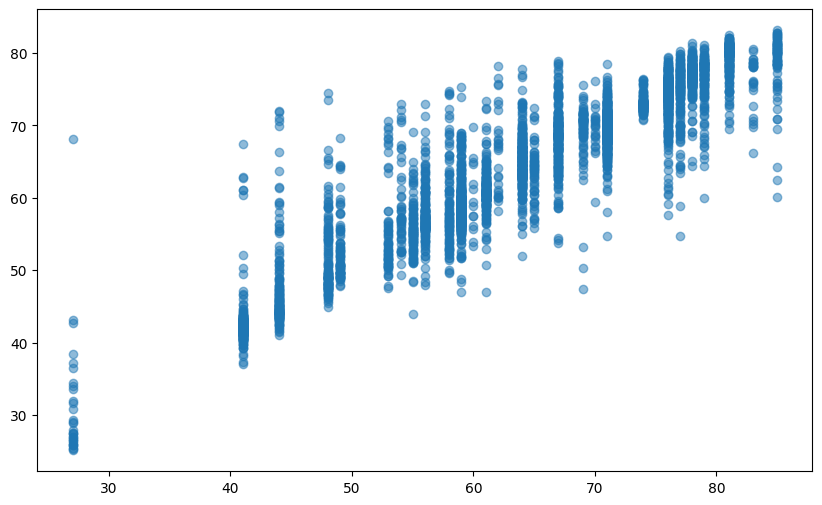

In [58]:
plot_scatter(true_labels, predictions)

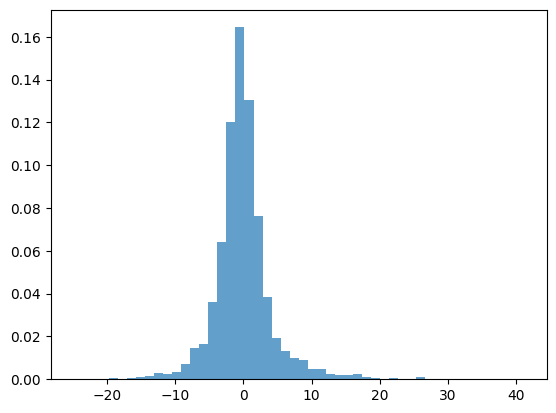

In [71]:
plot_error_distribution(true_labels, predictions)

In [ ]:
###### INTERPRETABILITY ######

'''
If I can implement grad cam, and then separate images by the type of scan they are, we may yet be able to use the model in order to
find some rhyme or reason to which regions of the brain are the most significant, depending on angle/type of scan.
'''